In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import altair as alt
from sublimpy import utils
from sublimpy import variables
from sublimpy import tidy

In [2]:
ls /Users/elischwat/Downloads/250917_for_Eli/ | grep ".nc"

230517_120045.nc
230518_132940.nc


In [3]:
fn = "/Users/elischwat/Downloads/250917_for_Eli/230518_132940.nc"

# Open a subset of one large file

In [4]:
ds = xr.open_dataset(fn, chunks="auto")  # Lazily opens the NetCDF file with Dask

# Get a slice so we just do a bit of processing
ds = ds.sel(frame=slice(0, 10)).compute()

In [5]:
# Let's just use 1 frame
ds_1frame = ds['irdata'].sel(frame=0)

In [6]:
# the data is "shifted" in the col axis.. we need to chop and concatenate. 
# This col value where the shift happens varies with frame...
# we will only deal with one frame for now.
right_side = ds_1frame.sel(col = slice(0,288))
left_side  = ds_1frame.sel(col = slice(289, 1024))
ds_1frame = xr.concat(
    [left_side, right_side],
    dim='col'
)

# Transpoe and then reverse rows so that it plots in a visually-spatially-correct way
ds_1frame = ds_1frame.T
ds_1frame = ds_1frame[::-1,::]

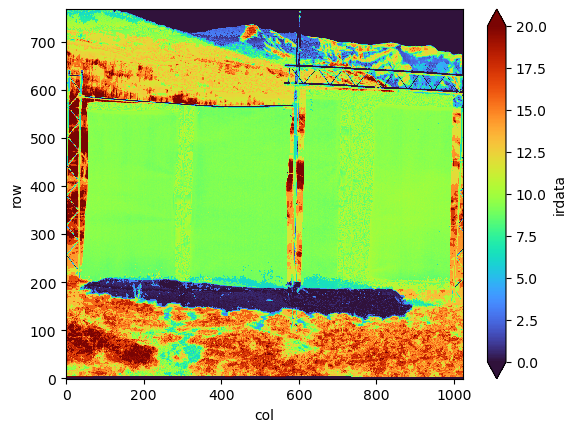

In [7]:
ds_1frame.plot(vmin=0,vmax=20, cmap='turbo')

find the "ground" - where the left pole "ends"

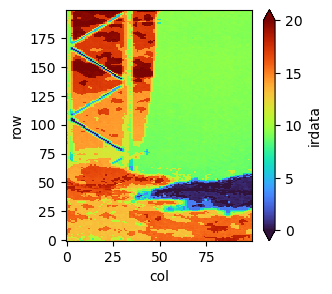

In [8]:
ds_1frame.sel(
    row=slice(150,350),
    col=slice(0, 100),
).plot(vmin=0,vmax=20, cmap='turbo', figsize=(3,3))

Looks like its at about row=205. We will grab all data above that 

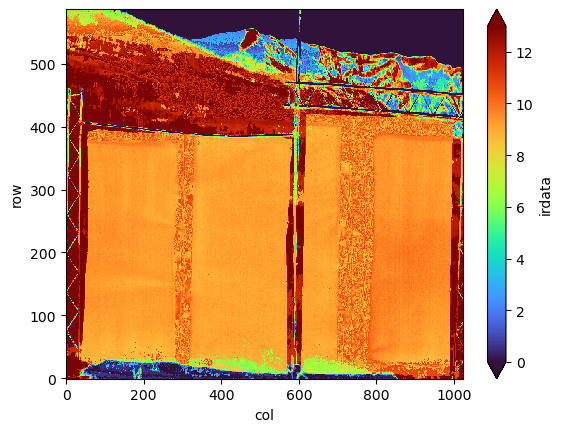

In [9]:
ds_1frame.sel(row=slice(180,ds_1frame.row.values.max())).plot(vmin=0,vmax=13, cmap='turbo')

In [10]:
ds_1frame_cropped = ds_1frame.sel(row=slice(180,ds_1frame.row.values.max()))

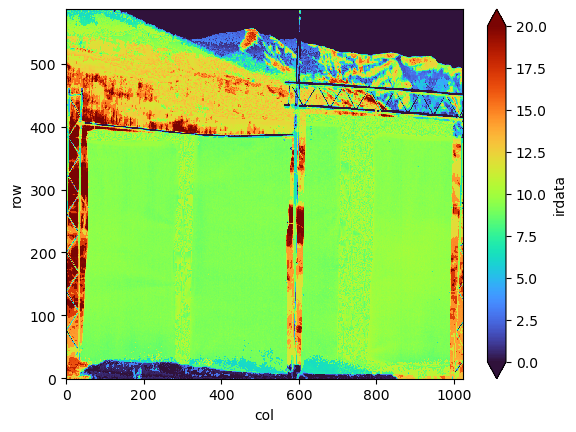

In [11]:
ds_1frame_cropped.plot(vmin=0,vmax=20, cmap='turbo')

Grab a subset of the data so col starts at and ends at the left and right boundaries of the two sheets.

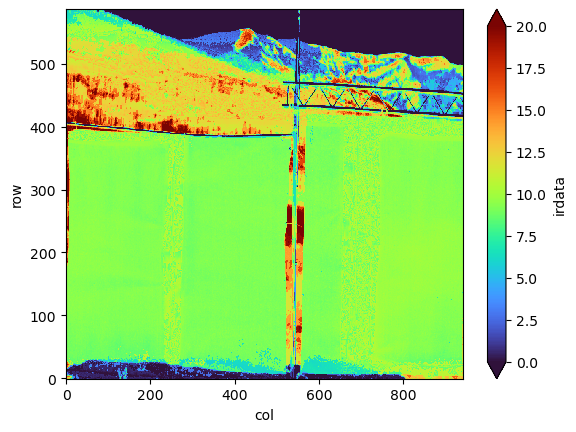

In [12]:
ds_1frame_cropped.sel(col=slice(49,990)).plot(vmin=0,vmax=20, cmap='turbo')

In [13]:
# this removes the left and right most edges
ds_1frame_cropped = ds_1frame_cropped.sel(col=slice(59,990))

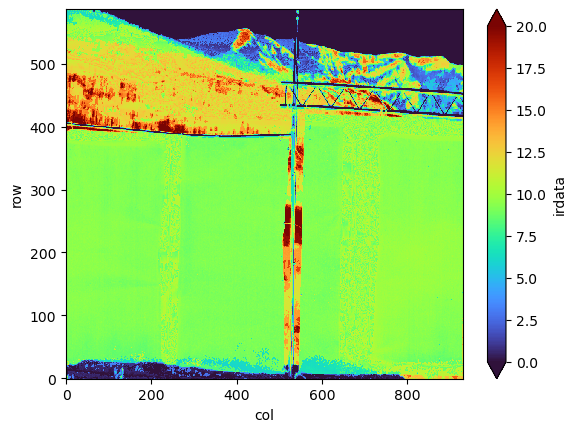

In [14]:
ds_1frame_cropped.plot(vmin=0,vmax=20, cmap='turbo')

Now let's cut off the top

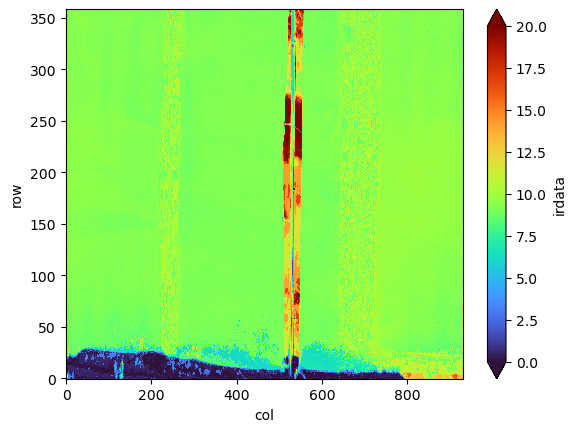

In [15]:
ds_1frame_cropped.sel(
    row = slice(0,359)
).plot(vmin=0,vmax=20, cmap='turbo')

In [16]:
ds_1frame_cropped = ds_1frame_cropped.sel(
    row = slice(0,359)
)

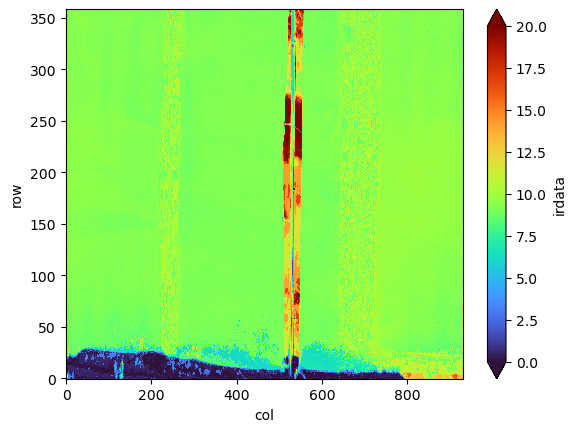

In [17]:
ds_1frame_cropped.plot(vmin=0,vmax=20, cmap='turbo')

# Find the snow-surface and set values below to 0

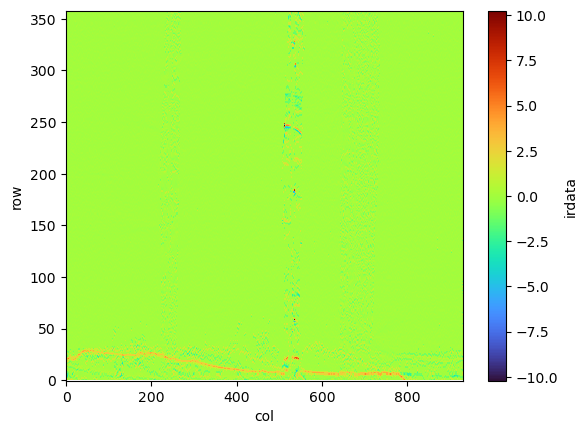

In [18]:
ds_1frame_cropped.diff(dim='row').rolling(row=2).median().plot(cmap='turbo')

In [19]:
import matplotlib.pyplot as plt

(0.0, 100.0)

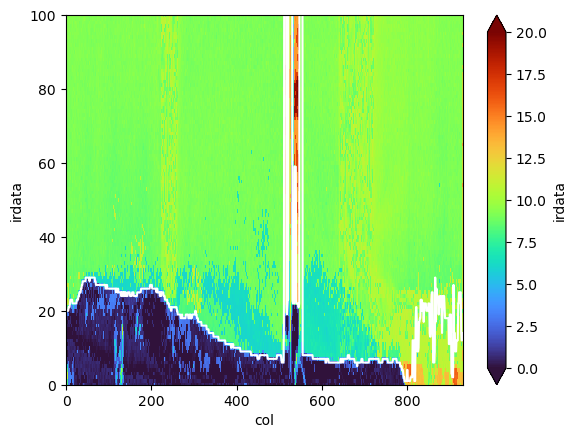

In [20]:
# Get the row index of the maximum value for each column
max_indices = ds_1frame_cropped.diff(dim='row').rolling(row=2).median().argmax(dim="row", skipna=True)


ds_1frame_cropped.plot(vmin=0,vmax=20, cmap='turbo')
max_indices.rolling(col=5).median().plot(color='white')
plt.ylim(0,100)

In [21]:
max_indices = max_indices.rolling(col=5).median()

In [22]:
ds_1frame_cropped = ds_1frame_cropped.where(ds_1frame_cropped.row > max_indices, other=0)

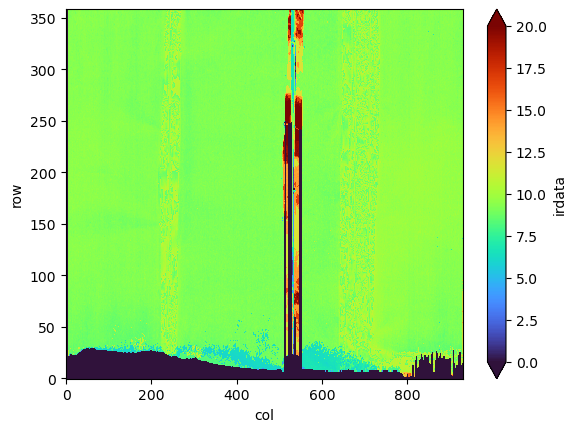

In [23]:
ds_1frame_cropped.plot(vmin=0,vmax=20, cmap='turbo')

Remove the data in between the two sheets

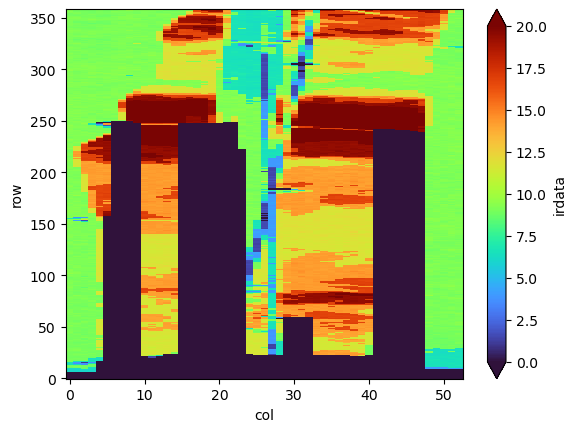

In [24]:
ds_1frame_cropped.sel(
    col = slice(507,560)
).plot(vmin=0,vmax=20, cmap='turbo')

In [25]:
ds_1frame_cropped = ds_1frame_cropped.where(
    (ds_1frame_cropped.col < 507)
    | (ds_1frame_cropped.col > 560)
)

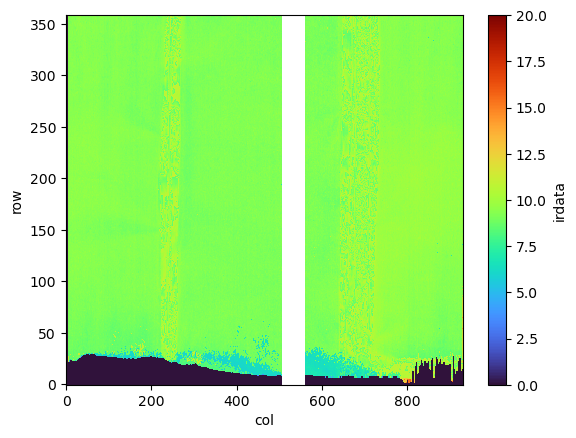

In [26]:
ds_1frame_cropped.plot(vmin=0,vmax=20, cmap='turbo')

Convert the row and column indices to meters

Length relations: 
* the fixation of the left horizontal bar at the leftmost vertical bar is at 1.90m above the (bare) surface. 
* The left horizontal bar from vertical post to vertical post is 2.92m long. 
* The right horizontal bar from vertical post to vertical post is 2.06m. The bottom of the right horizontal bar is 2.26m above bare ground at the middle vertical post. Sorry, a lot of numbers...

i.e...
* total width of the col dimension, i.e. from the left edge of left sheet to right edge of right sheet is: 2.06 + 2.92 = **4.98 meters**
* total height of the row dimension, i.e. from where the pole meets the ground to the top support pole, is **1.9 meters**

In [27]:
TOTAL_WIDTH = 4.98
TOTAL_HEIGHT = 1.9

## FOR THE GRIDDED DATA
# create coords x and why, scaling the col and row dimensions using the dimensions of the observations/sheets
ds_1frame_cropped = ds_1frame_cropped.assign_coords(
    x = TOTAL_WIDTH * ds_1frame_cropped.col / len(ds_1frame_cropped.col),
    z = TOTAL_HEIGHT * ds_1frame_cropped.row / len(ds_1frame_cropped.row)
)

# replace the dims with the physical ones
ds_1frame_cropped = ds_1frame_cropped.to_dataframe().reset_index(drop=True).set_index(['x', 'z']).to_xarray().irdata.T

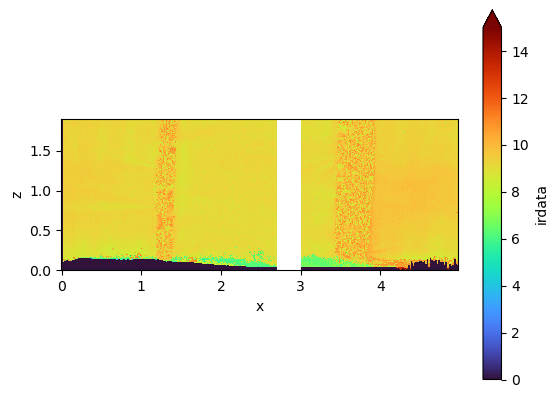

In [28]:
import matplotlib.pyplot as plt
ds_1frame_cropped.plot(vmin=0,vmax=15, cmap='turbo')
plt.gca().set_aspect('equal')

### Apply Gaussian Smoothing Filter

In [29]:
from scipy.ndimage import gaussian_filter

sigma = 3

# Apply the gaussian_filter from SciPy to the DataArray using .apply()
# `keep_attrs=True` will retain the original metadata.
smoothed_da = xr.apply_ufunc(
    gaussian_filter,
    ds_1frame_cropped,
    input_core_dims=[['z', 'x']],
    output_core_dims=[['z', 'x']],
    kwargs={'sigma': sigma},
    dask='parallelized', # Use Dask for parallel computation on large arrays
    output_dtypes=[ds_1frame_cropped.dtype],
    keep_attrs=True,
    dask_gufunc_kwargs={'allow_rechunk': True}
)

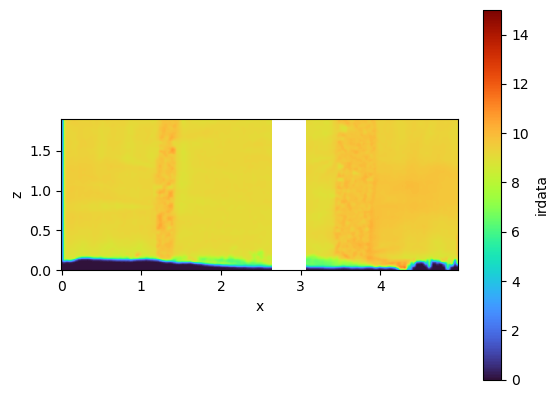

In [30]:
smoothed_da.plot(vmin=0,vmax=15, cmap='turbo')
plt.gca().set_aspect('equal')

In [31]:
ds_1frame_cropped = smoothed_da

Extract Profiles at 50cm intervals, use 10cm width, 2cm height, bins to get values

In [32]:
# get a dataframe for easy processing
df = ds_1frame_cropped.to_dataframe().reset_index()

# bin the z values
df = df.assign(
    z = pd.cut(df['z'], np.linspace(-0.02,2,102)).apply(
        lambda interval: interval.right
    )
)

Combine the datasets. Also, reindex into a higher resolution so that we can manipulate the data later.

In [33]:
z_high_res = np.linspace(0, 2, num=1001)  # Adjust num for desired resolution
z_high_res

array([0.   , 0.002, 0.004, ..., 1.996, 1.998, 2.   ])

Where should we extract profiles? Let's not go beyond x=4, because the way we had to crop the data makes it so there is no snow at the bottom beyond x=4. What about x=0?

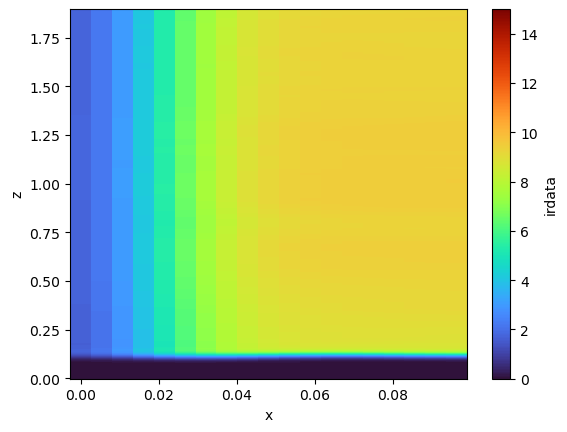

In [34]:
ds_1frame_cropped.sel(x=slice(0,0.10)).plot(vmin=0,vmax=15, cmap='turbo')

We see that data is noisy - let's extract data every 25cm, but make our first data point at 0.01

In [35]:
X = np.linspace(0.5, 4.0, 8)
X

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. ])

In [36]:

df_profiles = pd.DataFrame()
for val in X:
    profile = df.query(
            f"x > {val - 0.05}"
        ).query(
            f"x < {val + 0.05}"
        ).groupby('z', observed=True)[
            ['irdata']
        ].mean(
            
        ).assign(
            x = val
        ).reindex(
            z_high_res
        ).interpolate(
            method='linear'
        )
    df_profiles = pd.concat([df_profiles,profile])

In [37]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [38]:
src = df_profiles.reset_index()
alt.Chart(
    src
).mark_line().encode(
    alt.X('irdata:Q'),
    alt.Y('z:Q'),
    alt.Color('x:O'),
    order='z:Q',
    tooltip='x'
).properties(width = 300, height = 300)

alt.Chart(...)

In [39]:
src = df_profiles.reset_index().query("x < 3.5").query("z < 0.20")
alt.Chart(
    src
).mark_line(point=True).encode(
    alt.X('irdata:Q'),
    alt.Y('z:Q'),
    alt.Color('x:O'),
    # alt.Facet('x:O', columns=4),
    order='z:Q',
    tooltip='x'
).properties(width = 300, height = 300)

alt.Chart(...)

I need to adjust the profiles for the variable snow surface. 

Automated method:


Steps:
1. (Optional) Interpolate along the lines to get a higher resolution dataset
2. Find z value where irdata = 0 - actually, it looks like things will work better if I use irdata = 2?
3. Adjust z values for that profile

In [41]:
adjusted_df_list = []
for val in X:
    src = df_profiles.query(f"x == {val}")
    src.irdata = src.irdata.round(2)
    idx = src['irdata'][::-1].idxmin()
    src.index = src.index - idx + 0
    adjusted_df_list.append(src)
df_adjusted = pd.concat(adjusted_df_list)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_47366/3985065836.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  src.irdata = src.irdata.round(2)
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_47366/3985065836.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  src.irdata = src.irdata.round(2)
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_47366/3985065836.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [44]:
alt.Chart(
    df_adjusted.reset_index().query("z < 0.14")
).mark_line().encode(
    alt.X('irdata:Q'),
    alt.Y('z:Q'),
    alt.Color('x:O'),
    # alt.Facet('x:O', columns=4),
    order='z:Q',
    tooltip='x'
).properties(width = 300, height = 300) | alt.Chart(
    df_adjusted.reset_index()
).mark_line().encode(
    alt.X('irdata:Q'),
    alt.Y('z:Q'),
    alt.Color('x:O'),
    order='z:Q',
    tooltip='x'
).properties(width = 300, height = 300)

alt.HConcatChart(...)

Set the internal boundary layer depth - above that height, we will not calculate advected energy

We manually select this based on the "blending height" we observe above

In [55]:
MAX_INTEGRATION_DEPTH = 0.4

# Calculate sensible heat flux into snow

Open sos data 

In [45]:
sos_tidy_fn = f"../paper1/process_slow_data/tidy_df_20221101_20230619_planar_fit_multiplane_q7_flags9000_pf10.parquet"
sos_df = pd.read_parquet(sos_tidy_fn)
sos_df['time'] = pd.to_datetime(sos_df['time'])
sos_df = utils.modify_df_timezone(sos_df, 'UTC', 'US/Mountain')

In [46]:
alt.Chart(
    sos_df[sos_df.variable.isin(
        ['w_tc__3m_c', 'w_tc__3m_d', 'w_tc__3m_ue', 'w_tc__3m_uw',
         'spd_3m_c', 'spd_3m_d', 'spd_3m_ue', 'spd_3m_uw']
    )].set_index(
    'time'
).loc['20230518'].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Column('measurement'),
    alt.Color('tower:N')
).resolve_scale(y='independent').properties(width=300, height=150)


alt.Chart(...)

$$ < H_O > = H_u + Q_a $$

where $H_u$ is the heat flux upwind of the snow-patch, $Q_a$ is the advected energy. 

$$ Q_a = \frac{\Delta S}{X_s} $$

$\Delta$ S is the *difference in horizontal transport of heat* between the upwind and downwind edges of the snow-patch, and $X$ is the length of the snow-patch.

$$ Q_a = \frac{\Delta S}{X_s} = \frac{\rho c_p}{X_s} \int^B_0 U(z)  \Big(T(z)_u - T(z)_s \Big) dz $$

We will assume the following for $U(z)$

$$ U(z) = \frac{u_*}{k} \text{ln} \frac{z}{z_0} $$

In [47]:
sos_data_moment = sos_df.set_index('time').loc['20230518 1200']

Solve for z0

$$ z_0 = z \text{exp} \Big[ - \frac{k}{u_*} U(z) \Big]$$

In [48]:
from metpy.units import units

In [49]:
z = 2 * units("meters")
u_star = sos_data_moment.query("variable == 'u*_2m_c'").value.iloc[0] * units("m/s")
U = sos_data_moment.query("variable == 'spd_2m_c'").value.iloc[0] * units("m/s")
k = 0.41 
H_u = sos_df.query("variable == 'w_tc__3m_uw'").set_index('time').loc['20230517 1200'].value * units(
    "kelvin * m/s"
)

In [50]:
z_0 = z * np.exp(
    - (k / u_star) * U
)
z_0

<Quantity(0.00913365717610467, 'meter')>

In [51]:
def get_U(z):
    return (u_star.magnitude/k)*np.log(z / z_0.magnitude)

In [52]:
U_df = df_adjusted.query("x == 0.5").reset_index().query("z > 0").drop(
    columns=['irdata', 'x']
)
U_df['U'] = U_df['z'].apply(get_U)
U_df = U_df.query(f"z > {z_0.magnitude}")
U_df.loc[0] = 0
U_df = U_df.set_index('z').sort_index()
U_df.head()

U
z              
0.000  0.000000
0.010  0.127572
0.012  0.384241
0.014  0.601252
0.016  0.789235

Calculate $Q_a$ for a different distnaces into the snow patch that we extracted temp profile data for.

$$ Q_a = \frac{\Delta S}{X_s} = \frac{\rho c_p}{X_s} \int^B_0 U(z)  \Big(T(z)_u - T(z)_s \Big) dz $$

In [53]:
c_p = 1000.5 * units('joules/(K*kg)')
rho_a = 1 * units("kg/m^3")

In [56]:
H_0_df = pd.DataFrame(columns=['X', 'Q_a'])

advection_df = df_adjusted[
    df_adjusted.index < MAX_INTEGRATION_DEPTH
].join(U_df).dropna()

for val in X:
    T_u = advection_df.query(f"x == 0.5")[['irdata', 'U']]
    T_s = advection_df.query(f"x == {val}")[['irdata', 'U']]
    T_combined = T_u.rename(columns={'irdata':'T_u'}).join(
        T_s.rename(columns={'irdata':'T_s'})[['T_s']]
    ).dropna()
    T_diff_values = (T_combined['T_u'] - T_combined['T_s']).values * units("kelvin")
    U_values = T_combined['U'].values * units("m/s")
    argument = ( U_values * T_diff_values )
    domain = T_combined.index.values * units("m")
    # Sometimes, T profiles have nans in them, and trapz returns zero when you operate on missing data
    if len(argument.magnitude) == 0:
        Q_a = np.nan * units("W/m^2")
    else:
        Q_a = (c_p * rho_a * np.trapz(argument, domain) / (val * units("m"))).to(units("W/m^2"))
    H_0_df = pd.concat([
          H_0_df,
          pd.DataFrame({'X': [val], 'Q_a': [Q_a.magnitude]})
     ])
H_0_df = pd.concat([
          H_0_df,
          pd.DataFrame({'X': [0], 'Q_a': [0]})
     ]).set_index('X')

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_47366/291964037.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  H_0_df = pd.concat([


In [57]:
H_0_df.loc[0, 'Q_a'] = 0

In [58]:
alt.Chart(H_0_df.reset_index()).mark_line().encode(
    alt.X('X:Q'),
    alt.Y('Q_a:Q')
).properties(width=400, height=200)

alt.Chart(...)